In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

In [74]:
L = 100
N = 128
log2N = int(np.log2(N))
g = 9.81

In [75]:
n = (np.linspace(0, N-1, N)).astype(int)

nx, ny = np.meshgrid(n, n)
deltaK = 2*np.pi/L
uv = np.stack((nx, ny), axis=2)

In [76]:
K =  2*np.pi*(uv-0.5*N)
k = np.linalg.norm(K, axis=2)+0.00001
k = np.reshape(k, (*k.shape, 1))
omega = np.sqrt(g*k)

In [77]:
eta0 = np.random.normal(size=(N, N))
eta1 = np.random.normal(size=(N, N))

In [78]:
def Spectrum(K, wind, wind_dir):
    g = 9.81
    k = np.linalg.norm(K, axis=2)+0.00001
    omega = np.sqrt(g*k)
    alpha = 0.0081
    Sp = alpha*g*g/np.power(omega, 5)
    omega_p=0.855*g/wind
    Spm = Sp*np.exp(-5.*np.power(omega_p/omega, 4.)/4)
    D_theta = np.power(np.abs(np.dot(K/k.reshape((*k.shape, 1)), wind_dir)), 4)
    # print((K/k.reshape((*k.shape, 1))).shape, k.shape, D_theta.shape)
    return Spm*D_theta*0.5*np.sqrt(g/k)

In [79]:
wind = 5
wind_dir = np.array([1./np.sqrt(2), 1./np.sqrt(2)])
F = 10

In [80]:
P_k = Spectrum(K, 50, np.array([1, 1])/np.sqrt(2))
P_minus_k = Spectrum(-K, 50, np.array([1, 1])/np.sqrt(2))
omega = np.sqrt(g*k[:,:,0])
h_0_k = (eta0-1j*eta1)*np.sqrt(2*P_k)*1e6
h_0_minus_k = (eta0-1j*eta1)*np.sqrt(2*P_k)*1e6

In [81]:
print(np.amin(P_k), np.amax(P_k))

0.0 5.77253994441574e-06


In [82]:
t=1

h_k_t = 0.5*h_0_k*np.exp(-1j*omega*t)+0.5*h_0_k*np.exp(1j*omega*t)
h_k_t_ri = np.stack((h_k_t.real, h_k_t.imag), axis=2)
surf = np.absolute(np.fft.ifft2(h_k_t))


In [83]:
print(np.amin(surf), np.amax(surf))

0.0024664180281789593 1.3898298643425466


In [84]:
plot_args = {'rcount': N/2, 'ccount': N/2, 'cmap':
             "jet", 'linewidth': 0.01, 'antialiased': True, 'color': 'w',
             'shade': True}

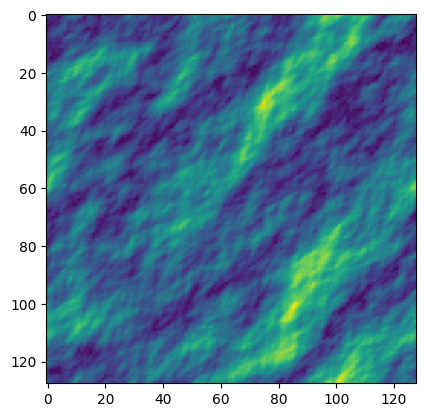

In [85]:
plt.imshow(surf)

# IFFT

In [86]:
def rev_bit(log2N):
    N = np.power(2, log2N)
    arr = []
    for i in range(N):
        bin_str = bin(i)[2:]
        bin_str = '0'*(log2N-len(bin_str))+bin_str

        arr.append(int(bin_str[::-1], 2))
        # arr.append('0b'+'0'*(log2N-len(bin_str))+bin_str)

    return np.array(arr, dtype=int)

In [87]:
# N = 8
# log2N = int(np.log2(N))

In [88]:
rev = rev_bit(log2N)
twid_arr = np.zeros((N, log2N, 4), dtype='f4')
for i in range(log2N):
    for n in range(N):
        top_wing = np.mod(n, np.power(2, i+1))<np.power(2, i)
        span = np.power(2, i)
        twi = np.exp(1j * 2 * np.pi * n / (2*span))
        if i == 0:
            if top_wing:
                twid_arr[n, i] = [twi.real, twi.imag, rev[n], rev[n+span]]
            else:
                twid_arr[n, i] = [twi.real, twi.imag, rev[n-span], rev[n]]
        else:
            if top_wing:
                twid_arr[n, i] = [twi.real, twi.imag, n, n+span]
            else:
                twid_arr[n, i] = [twi.real, twi.imag, n-span, n]

In [103]:
W = np.zeros((N, log2N, 4), dtype='f4')

for stage in range(log2N):
    span = int(np.power(2, stage+1))
    h_span = int(span/2) # half span
    for k in range(N):
        twi = np.exp(1j * 2 * np.pi * k / span)
        top = k % span < h_span

        if stage == 0:
            if top:
                W[k, stage] = [twi.real, twi.imag, rev[k], rev[k+h_span]]
            else:
                W[k, stage] = [twi.real, twi.imag, rev[k-h_span], rev[k]]
        else:
            if top:
                W[k, stage] = [twi.real, twi.imag, k, (k+h_span)]
            else:
                W[k, stage] = [twi.real, twi.imag, (k-h_span), k]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


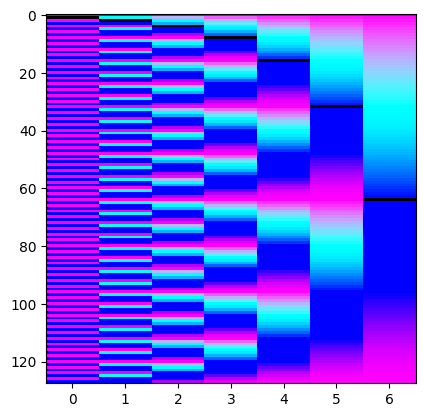

In [99]:
plt.imshow(twid_arr,aspect=log2N/N, interpolation="nearest")
plt.show()

In [100]:
spectrum = np.zeros((N, 2))
spectrum [2, 0] = 1

In [148]:
def FFT(nn, N, spectrum):
    pingpong0 = np.zeros((N, 2), dtype='f4')
    pingpong1 = np.zeros((N, 2), dtype='f4')
    pingpong0=spectrum.copy().astype('f4')
    for stage in range(nn):
        for n in range(N):
            twid_row = W[n, stage]
            w = twid_row[0]+1j*twid_row[1]

            idx1 = int(twid_row[2])
            idx2 = int(twid_row[3])

            g = pingpong0[idx1][0]+1j*pingpong0[idx1][0]
            h = pingpong0[idx2][0]+1j*pingpong0[idx2][0]

            res = g+w*h

            pingpong1[n] = [res.real, res.imag]
        
        if stage<nn-1:
            pingpong0, pingpong1 = pingpong1, pingpong0
    
    return pingpong1

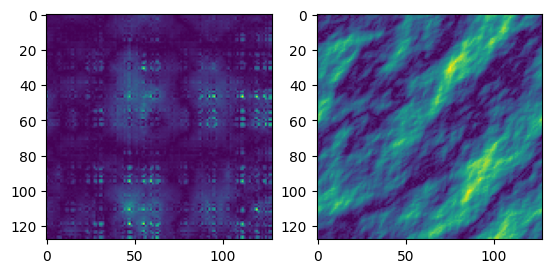

In [150]:
#2d FFT
stage1 = np.zeros((N, N, 2), dtype='f4')
stage2 = np.zeros((N, N, 2), dtype='f4')
res1 = np.zeros((N, N, 2), dtype='f4')
res2 = np.zeros((N, N, 2), dtype='f4')
h_k_t_ri = np.stack((h_k_t.real, h_k_t.imag), axis=2)

for r in range(N):
    stage1[:, r] = FFT(log2N, N, h_k_t_ri[:, r])
    stage2[:, r, 0] = np.fft.ifft(h_k_t[:, r]).real
    stage2[:, r, 1] = np.fft.ifft(h_k_t[:, r]).imag
for r in range(N):
    res1[r, :]= FFT(log2N, N, stage1[r, :])
    res2[r, :, 0] = np.fft.ifft(stage2[r, :, 0]+1j*stage2[r, :, 1]).real
    res2[r, :, 1] = np.fft.ifft(stage2[r, :, 0]+1j*stage2[r, :, 1]).imag
plt.subplot(121)
plt.imshow(np.absolute(res1[:,:,0]))
plt.subplot(122)
plt.imshow(np.absolute(res2[:,:,0]))
plt.show()